<a href="https://colab.research.google.com/github/subraja1810/BERT/blob/Master/CS18B1059final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install bert-for-tf2


In [42]:
import tensorflow as tf
from tensorflow import keras

In [44]:
!pip install transformers
!pip install praw

In [45]:
from transformers import TFAutoModelForTokenClassification, AutoTokenizer 
from matplotlib import pyplot as plt 
import numpy as np
import praw

In [46]:
model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english") 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing TFBertForTokenClassification: ['dropout_147']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english and are newly initialized: ['dropout_221']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
label_list = [
    "O",       # Outside of a named entity
    "B-MISC",  # Beginning of a miscellaneous entity immediately after another miscellaneous entity
    "I-MISC",  # Miscellaneous entity
    "B-PER",   # Beginning of a person's name immediately after another person's name
    "I-PER",   # Person's name
    "B-ORG",   # Beginning of an organisation immediately after another organisation
    "I-ORG",   # Organisation
    "B-LOC",   # Beginning of a location immediately after another location
    "I-LOC"    # Location
]

In [48]:
reddit = praw.Reddit(client_id='3PQwAJT-jv_t2g', 
                     client_secret='Lj2yqyiO-r5RO-K-7NAM7ABx9mL4qg',
                     user_agent='RedditBoo')

In [49]:
def replies_of(top_comments, comment_list):
    if len(top_comments.replies) == 0:
        return
    else:
        for num, comment in enumerate(top_comments.replies):
            try:
                comments_list.append(str(comment.body))
            except:
                continue
            replies_of(comment, comments_list)

In [50]:
count = 0
final_dict = {'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []} #BERT recognised tags for its pre-trained vocabulary.
word_temp = ''
current_tag = ''
old_tag = ''
print_dict = {}
print(final_dict)

{'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []}


In [51]:
list_of_subreddit = ['marvelstudios']

In [79]:
for j in list_of_subreddit:
    top_posts = reddit.subreddit(j).top('month', limit=1)
    comments_list = [] #Data fetched.
    # save subreddit comments in dataframe
    for submission in top_posts:
        submission_comm = reddit.submission(id=submission.id)
        comments_list.append(str(submission.title))

        for count, top_comments in enumerate(submission_comm.comments):
            try:
                replies_of(top_comments, comments_list)
            except:
                continue

print(comments_list)         
print(len(comments_list))       

['Chris Pratt confirms he is in Thor: Love and Thunder', "Guy has more lines in his biceps than the segments that make up my body's polygon.", 'More lines in his biceps than he has in the movie.', 'Why talk when the action can speak for itself?', '~~Mjolnir~~ (rip) ***Stormbreaker*** will probably do a lot of talking.', 'He got Mjolnir back. He has both.', "Cap took Mjolnir back to it's original timeline", 'What happened when Thor of the past discovered Thor of the future had stolen his hammer?', 'It was brought back the second it disappeared so past Thor never would have seen it disappear.', 'Can you imagine if he accidentally broke it again in the fight against Thanos? It would be funny if (past) Thor just woke up one day, and Mjolnir was just sitting there in pieces.', '“Cap”? You call him cap?', '"I understood that reference!"', 'Endgame he was looking more "Mr. Rogers" - ya know?', "They took Mjolnir back at the end of Endgame when Cap returned the stones  \n\n\nI do wonder if the

In [53]:
for sequence in comments_list:
    if len(sequence) > 512: #BERT token limitaton.
        continue
    # Standard Tokenization
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
    inputs = tokenizer.encode(sequence, return_tensors="tf")
    outputs = model(inputs)[0]
    predictions = tf.argmax(outputs, axis=2)
    #print(predictions)
    # Tokenized input
    list_bert = [(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]
    for i in list_bert:
        if i[1] in ['O', 'B-MISC', 'I-MISC']:
            if len(current_tag) > 0:
                without_space_word = word_temp.strip()
                if len(without_space_word) > 1:
                    final_dict[current_tag].append(without_space_word)
            count = 0
            word_temp = ''
            current_tag = ''
            continue
        else:
            current_tag = i[1]

            if old_tag != current_tag and len(old_tag) > 0:
                without_space_word = word_temp.strip()
                if len(without_space_word) > 1:
                    final_dict[old_tag].append(without_space_word)
                count = 0
                word_temp = ''
                current_tag = ''

            if i[0].startswith('##'): 
                word_temp += i[0][2:].upper()
            elif i[1] in ['I-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG', 'B-PER']:
                word_temp += " " + i[0].upper()
                current_tag = i[1]
                count += 1
            old_tag = current_tag

In [71]:
print(inputs)

tf.Tensor(
[[  101  1753  6100  4277   117  1117  2584  1440  8750  4296  1303 25338
   1233   119   102]], shape=(1, 15), dtype=int32)


In [67]:
print(outputs)

tf.Tensor(
[[[ 9.9672947e+00 -1.6488843e+00 -1.0693026e+00 -1.9949121e+00
   -1.5880215e+00 -1.9581240e+00 -9.0423369e-01 -1.5711803e+00
    1.2412877e-01]
  [ 6.2852945e+00 -1.8719974e+00  1.1728743e+00 -2.4520042e+00
   -3.2254741e-02 -2.2290709e+00 -1.6039525e-01 -2.1474793e+00
    8.4699273e-01]
  [ 7.5978746e+00 -1.3010929e+00  1.0695266e+00 -2.3234572e+00
   -5.1562649e-01 -2.3635437e+00 -3.2602775e-01 -1.8356826e+00
    2.9823965e-01]
  [ 8.0849791e+00 -1.4439204e+00  7.1682209e-01 -2.3575535e+00
   -7.7869225e-01 -2.2144923e+00  3.4461591e-02 -2.2566307e+00
   -1.8541755e-01]
  [ 1.0234784e+01 -1.8851680e+00 -6.2752545e-01 -2.3225694e+00
   -7.2999740e-01 -2.2086473e+00 -2.0174064e-01 -1.9460380e+00
   -7.2959214e-01]
  [ 1.0279599e+01 -2.2838995e+00 -5.8827388e-01 -2.7027271e+00
   -2.1087019e-01 -2.2517984e+00 -3.9841421e-03 -2.0840526e+00
   -9.1560721e-01]
  [ 9.4627790e+00 -1.9833572e+00  7.3114902e-01 -3.1280410e+00
   -5.6226298e-02 -2.4120626e+00 -5.2719718e-01 -2.46356

In [68]:
sequence,tokens

('Not gonna lie, his legs look fucking tiny here lol.',
 ['[CLS]',
  'Not',
  'gonna',
  'lie',
  ',',
  'his',
  'legs',
  'look',
  'fucking',
  'tiny',
  'here',
  'lo',
  '##l',
  '.',
  '[SEP]'])

In [54]:
print(final_dict)
print_dict['Location']=list(set(final_dict['I-LOC']+final_dict['B-LOC']))
print_dict['Organisation']=list(set(final_dict['I-ORG']+final_dict['B-ORG']))
print_dict['Person Name']=list(set(final_dict['I-PER']+final_dict['B-PER']))
print('')
print(print_dict)

{'I-LOC': ['CARIBBEAN', 'IRAQ', 'ASGARD', 'ENGLAND', 'AUSTRALIA', 'CALIFORNIA', 'STOCKHOLM', 'HOLLYWOOD', 'SILICON VALLEY', 'HOLLYWOOD', 'HOLLYWOOD', 'CAPRI'], 'I-ORG': ['LNIR', 'STORMBREAKER', 'MJOLNIR', 'LNIR', 'JONIR', 'D & D', 'IMO', 'UMBRELLA ACADEMY', 'IMO', 'CVS', 'HO', 'WOL', 'NETFLIX', 'WCW', 'WWF', 'XF', 'WCW', 'WWF ( E', 'WWE', 'WCW', 'SUBURBAN COMMANDO', 'LINGSUPE', 'MILANO', 'FLEX', 'RDI', 'THOR', 'ROIDS', 'HEMSWORTH', 'MARVEL', 'AVENGERS', 'LOVE TROPIC THUNDER', 'MCU', 'MARVEL', 'MARVEL', 'DISNEY', 'HERODO', 'NETFLIX', 'GUARDIANS 3', 'GUARDIANS', 'GUARDIANS', 'GUARDIANS', 'GUARDIANS', 'MARVEL', 'GOTG', 'GUARDIANS', 'GUARDIANS', 'MARVEL', 'MARVEL', 'MIB INTERNATIONAL', 'ANCHOR ARMS', 'ARMANI', 'NATUROIDZ', 'OP', 'OP', 'THE', 'COSTCO', 'EROIDS', 'COM', 'SCARECROW BOAT', 'FPH', 'GUARDIANS'], 'I-PER': ['CHRIS PRATT', 'MJO', 'LNIR', 'CAP', 'THOR', 'THOR', 'THOR', 'THANOS', 'THOR', 'MJOLNIR', 'CAP', 'MR . ROGERS', 'CAP', 'FOSTER', 'THOR', 'THOR', 'THOR', 'THOR', 'GROOT', 'CONAN

In [55]:
locations=final_dict['I-LOC']+final_dict['B-LOC']
organisations=final_dict['I-ORG']+final_dict['B-ORG']
names=final_dict['I-PER']+final_dict['B-PER']

In [56]:
from collections import Counter
loc_count=Counter(locations)
org_count=Counter(organisations)
names_count=Counter(names)

In [57]:
loc_key=loc_count.keys()
loc_value=loc_count.values()
org_key=org_count.keys()
org_value=org_count.values()
names_key=names_count.keys()
names_value=names_count.values()

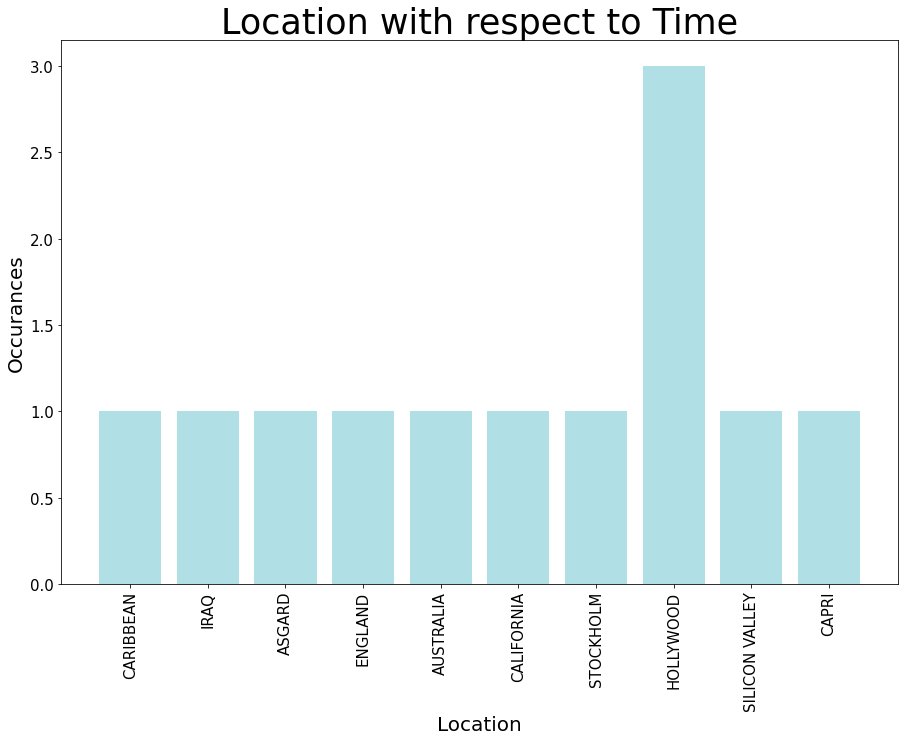

In [78]:
height=10
width=15
plt.figure(figsize=(width,height))
plt.bar(loc_key,loc_value,color='powderblue')
plt.title('Location with respect to Time', fontsize=35)
plt.xlabel('Location', fontsize=20)
plt.ylabel('Occurances', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

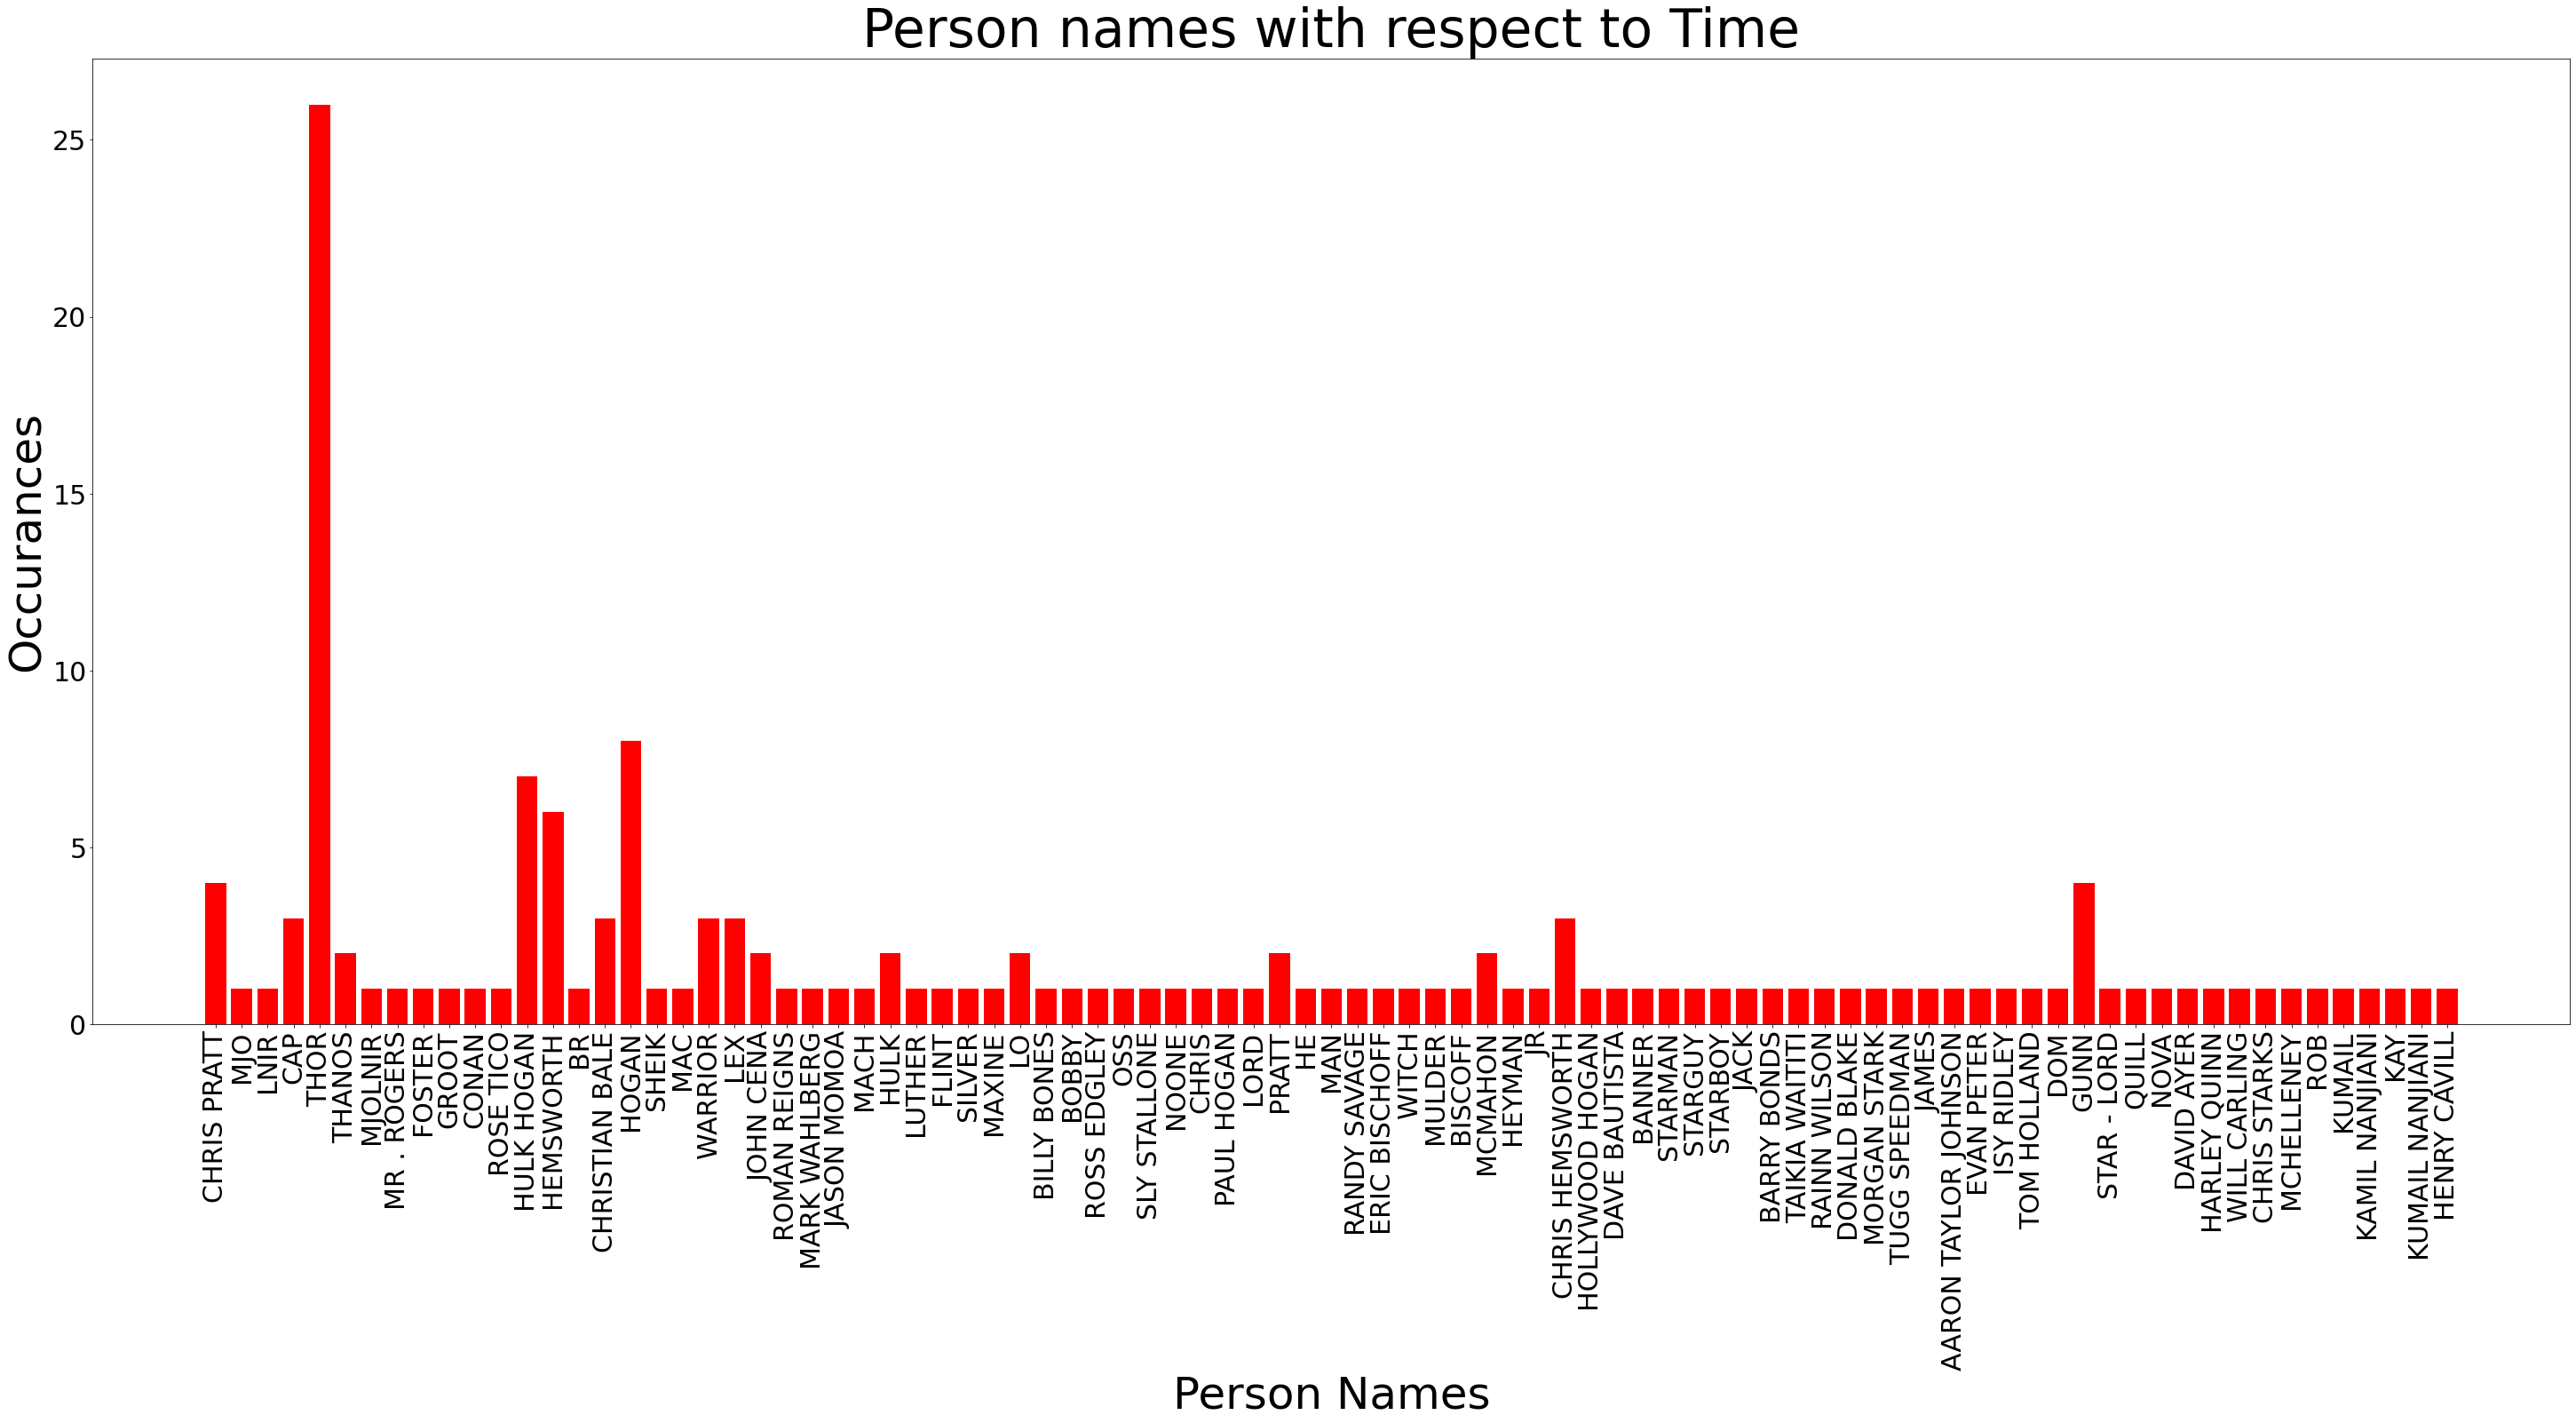

In [75]:
height=20
width=50
plt.figure(figsize=(width,height))
plt.bar(names_key,names_value, color='red')
plt.title('Person names with respect to Time', fontsize=60)
plt.xlabel('Person Names', fontsize=50)
plt.ylabel('Occurances', fontsize=50)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.show()

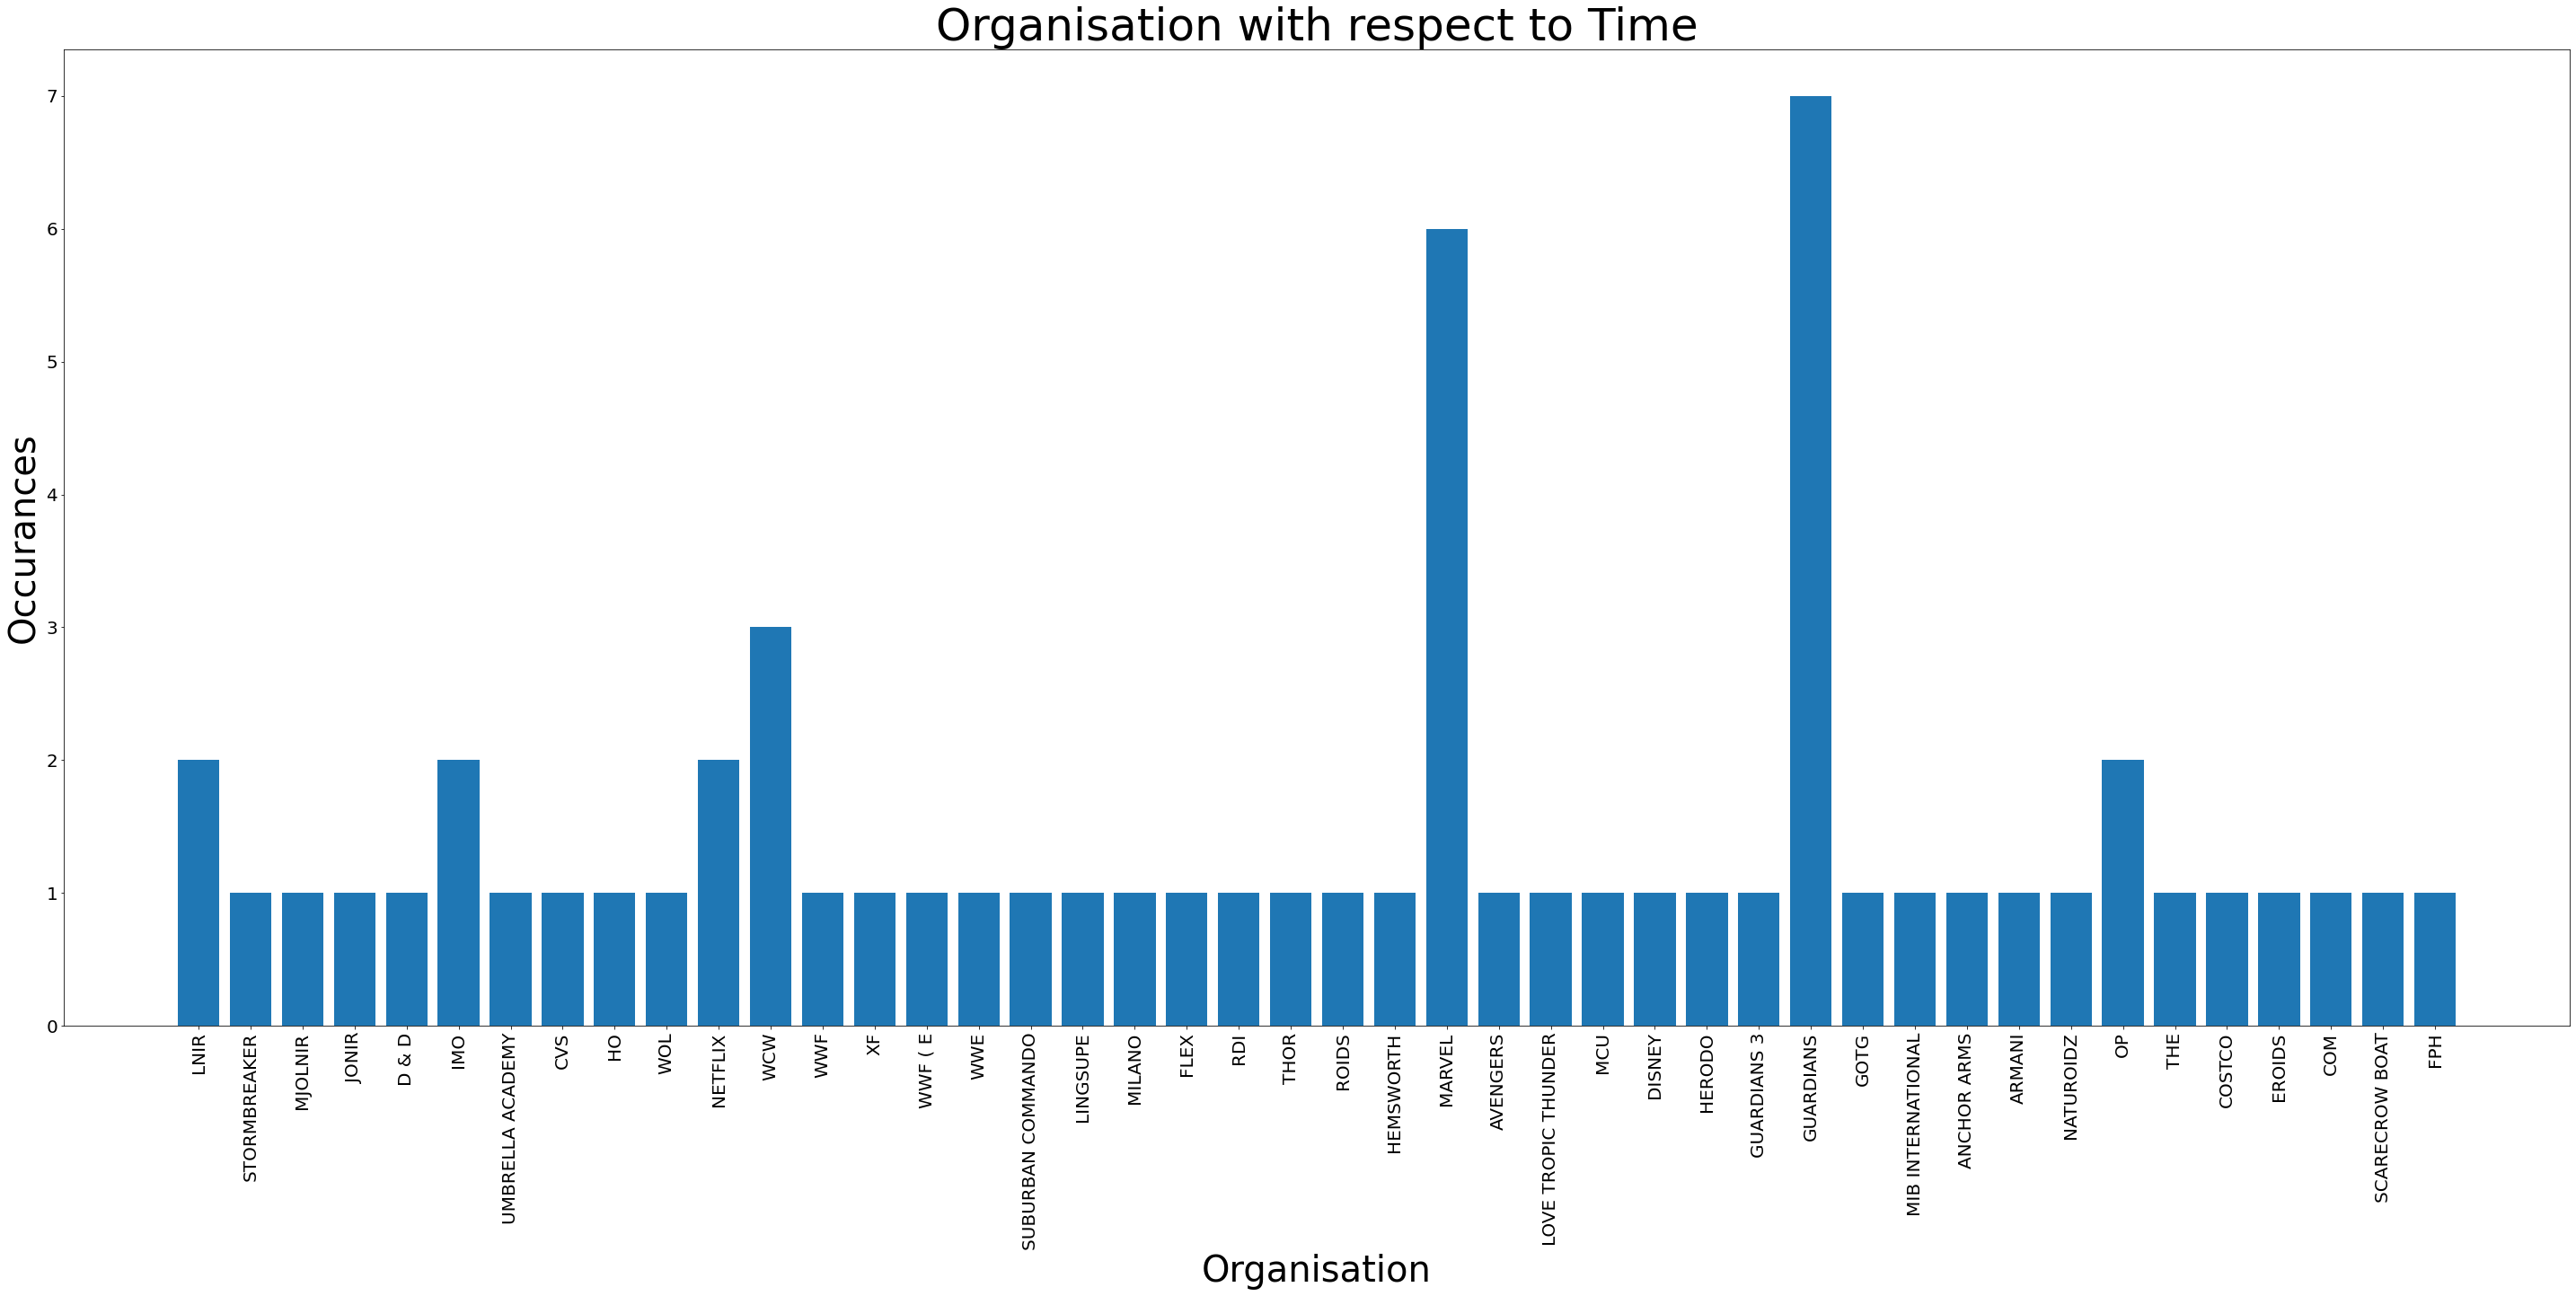

In [77]:
height=20
width=50
plt.figure(figsize=(width,height))
plt.bar(org_key,org_value)
plt.title('Organisation with respect to Time', fontsize=50)
plt.xlabel('Organisation', fontsize=40)
plt.ylabel('Occurances', fontsize=40)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
list_of_loc = final_dict['I-LOC']
#list_of_org = final_dict['I-ORG']
#list_of_person = final_dict['I-PER']
#list_of_misc = final_dict['I-MISC']
frequency = {}
for loc in list_of_loc:
  frequency[loc] = frequency.get(loc, 0) +1
  print(frequency)

In [ ]:
#outputs[0][6]

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-0.7641342 , -2.4077516 , -2.0843105 , -3.2465644 ,  0.10769157,
       -2.4875414 ,  1.225174  , -1.9893391 ,  7.9986925 ], dtype=float32)>

In [ ]:
#label_list[8]

'I-LOC'

In [ ]:
#sequence,tokens

('I am Ajay from Chennai',
 ['[CLS]', 'I', 'am', 'A', '##jay', 'from', 'Chennai', '[SEP]'])

In [ ]:
#predictions.numpy()[0]

array([0, 0, 0, 4, 4, 0, 8, 0])